In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


In [ ]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Изменение размера данных с (history_size,) на (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 300000

In [ ]:
tf.random.set_seed(13)

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<Axes: xlabel='Date Time'>], dtype=object)

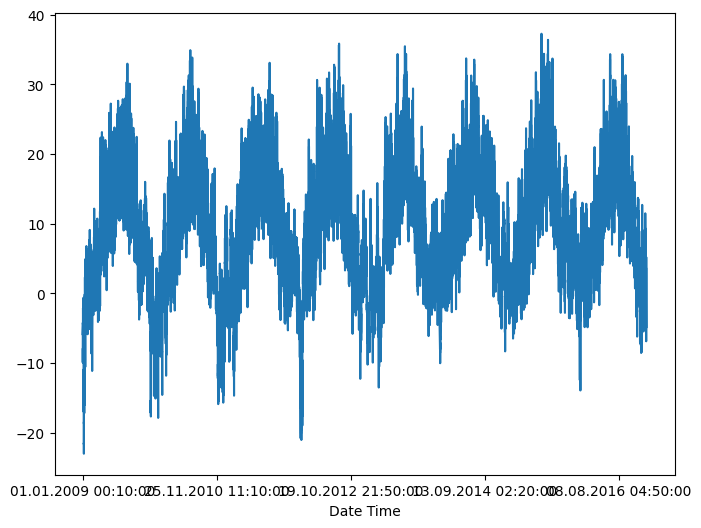

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Временной интервал для наблюдений')
print (x_train_uni[0])
print ('\n Целевая температура для прогнозирования')
print (y_train_uni[0])

Временной интервал для наблюдений
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Целевая температура для прогнозирования
-2.1041848598100876


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

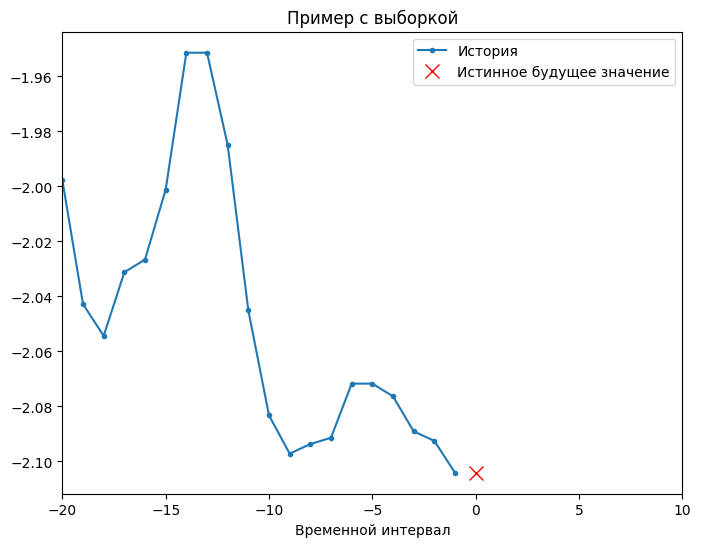

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['История', 'Истинное будущее значение', 'Прогноз модели']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Временной интервал')
  return plt
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

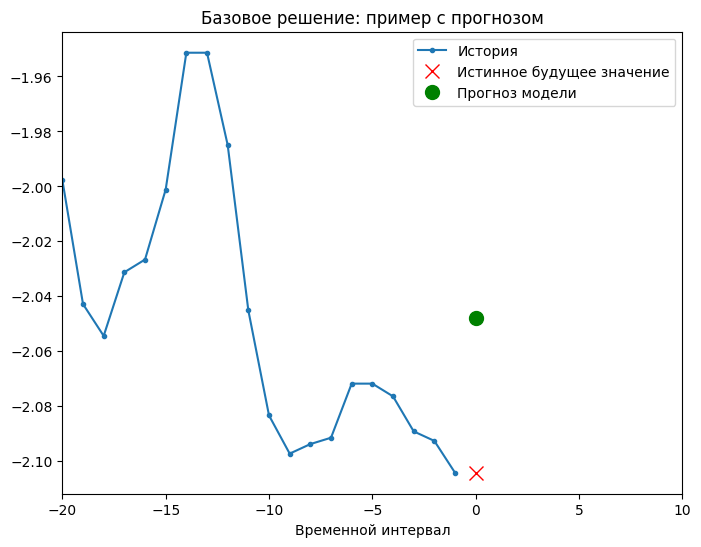

In [ ]:
def baseline(history):
  return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Базовое решение: пример с прогнозом')

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 1s 3ms/step
(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 6s 15ms/step - loss: 0.6044 - val_loss: 0.1622
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1448 - val_loss: 0.0403
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0529 - val_loss: 0.0304
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0452 - val_loss: 0.0260
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0297 - val_loss: 0.0239
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0317 - val_loss: 0.0230
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0290 - val_loss: 0.0219
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0273 - val_loss: 0.0210
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0269 - val_loss: 0.0196
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0246 - val_lo

8/8 [==============================] - 0s 4ms/step


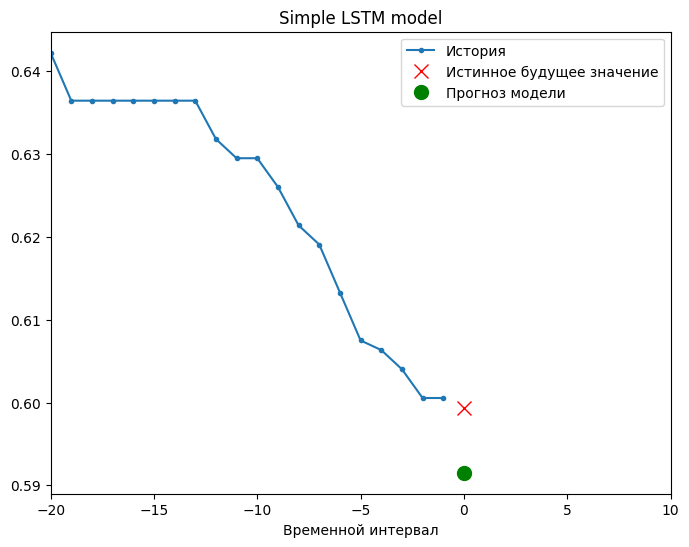

8/8 [==============================] - 0s 3ms/step


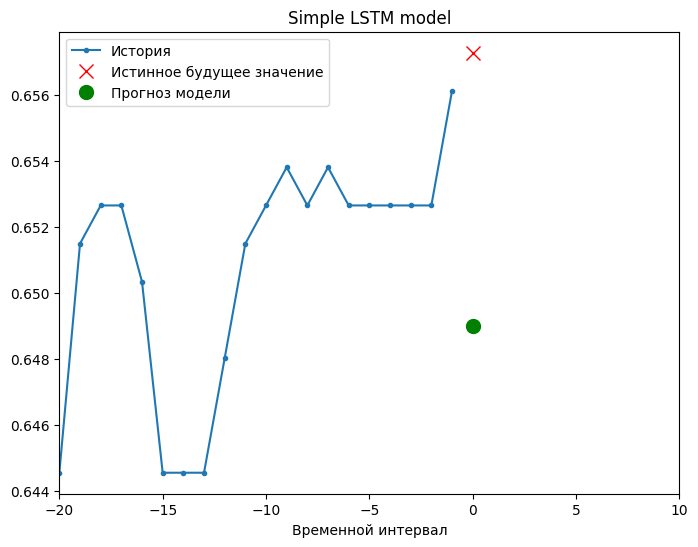

8/8 [==============================] - 0s 3ms/step


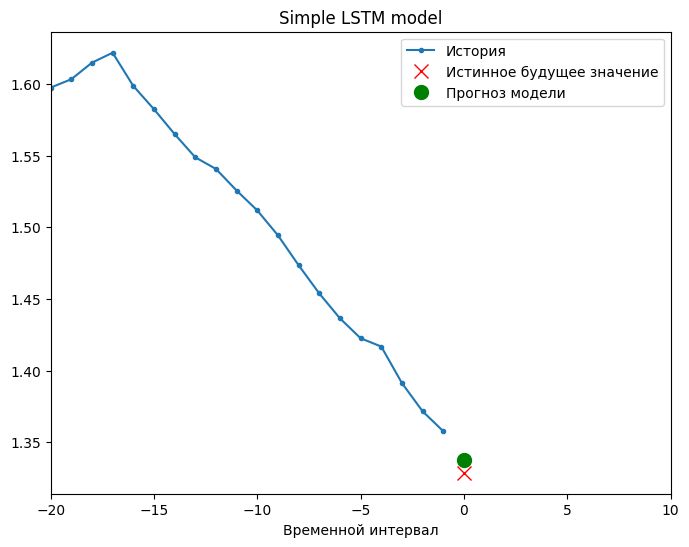

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [ ]:
#прогнозирование на основе многомерного временного ряда
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

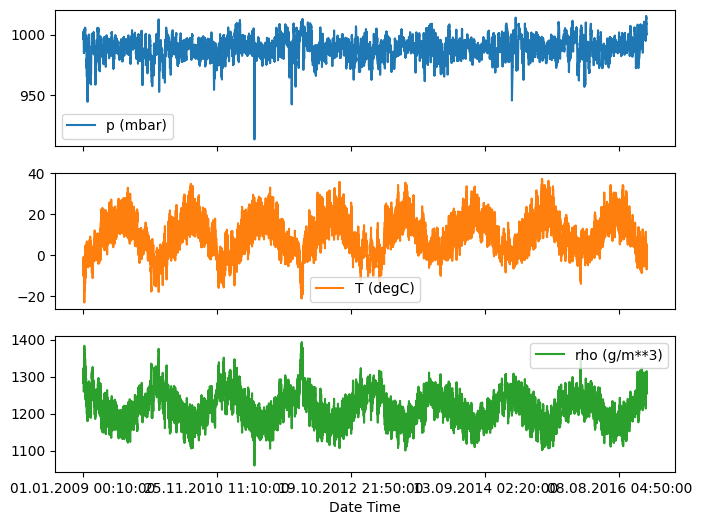

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 12ms/step
(256, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 23s 113ms/step - loss: 0.2665 - val_loss: 0.2571
Epoch 2/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2540 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 30s 149ms/step - loss: 0.2598 - val_loss: 0.2455
Epoch 4/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2563 - val_loss: 0.2403
Epoch 5/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2277 - val_loss: 0.2333
Epoch 6/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2402 - val_loss: 0.2539
Epoch 7/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2392 - val_loss: 0.2485
Epoch 8/10
200/200 [==============================] - 19s 97ms/step - loss: 0.2376 - val_loss: 0.2425
Epoch 9/10
200/200 [==============================] - 19s 97ms/step - loss: 0.2426 - val_loss: 0.2396
Epoch 10/10
200/200 [==============================] - 19s 95ms/step - loss: 

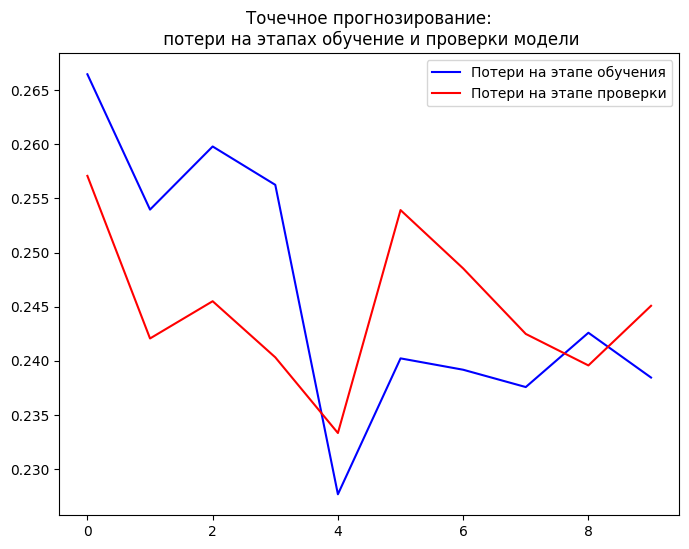

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()
plot_train_history(single_step_history,
                   'Точечное прогнозирование:\n потери на этапах обучение и проверки модели')

8/8 [==============================] - 0s 11ms/step


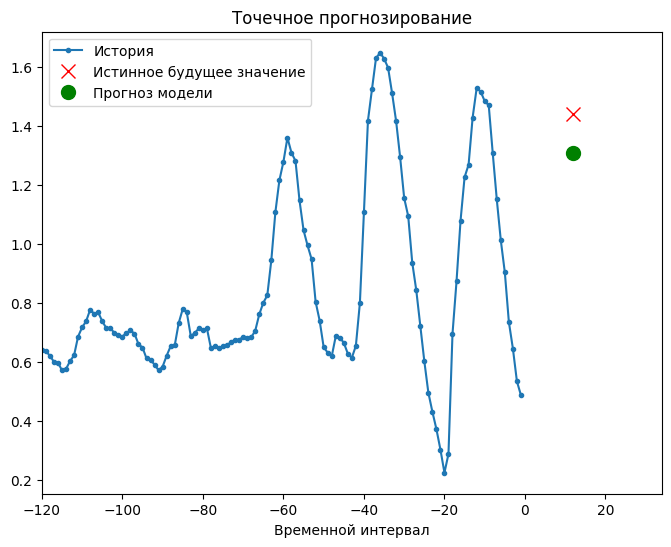

8/8 [==============================] - 0s 11ms/step


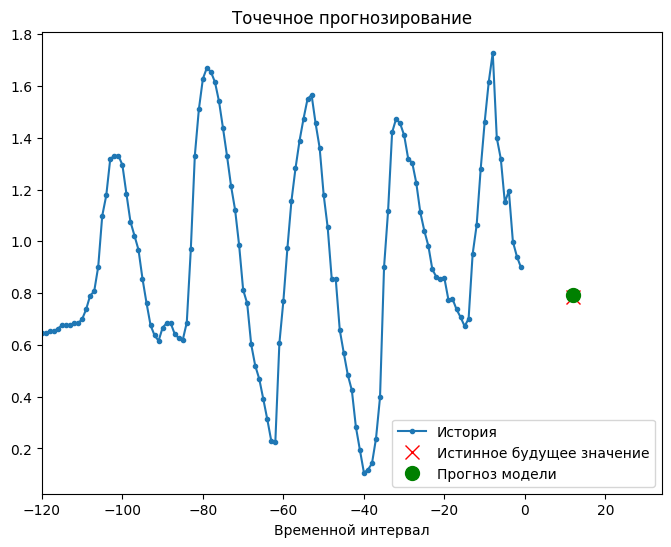

8/8 [==============================] - 0s 12ms/step


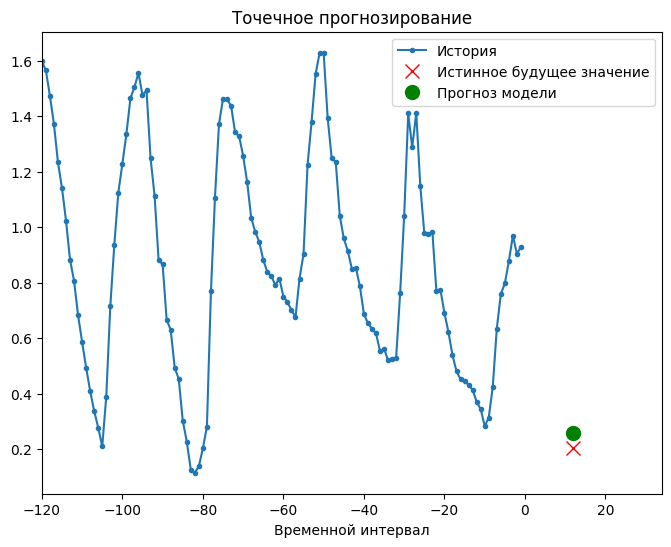

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Точечное прогнозирование')
  plot.show()

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Временной интервал для наблюдений : {}'.format(x_train_multi[0].shape))
print ('\n Целевая температура для прогнозирования : {}'.format(y_train_multi[0].shape))

Временной интервал для наблюдений : (120, 3)

 Целевая температура для прогнозирования : (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='История')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='Истинное будущее значение')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Прогноз модели')
  plt.legend(loc='upper left')
  plt.show()

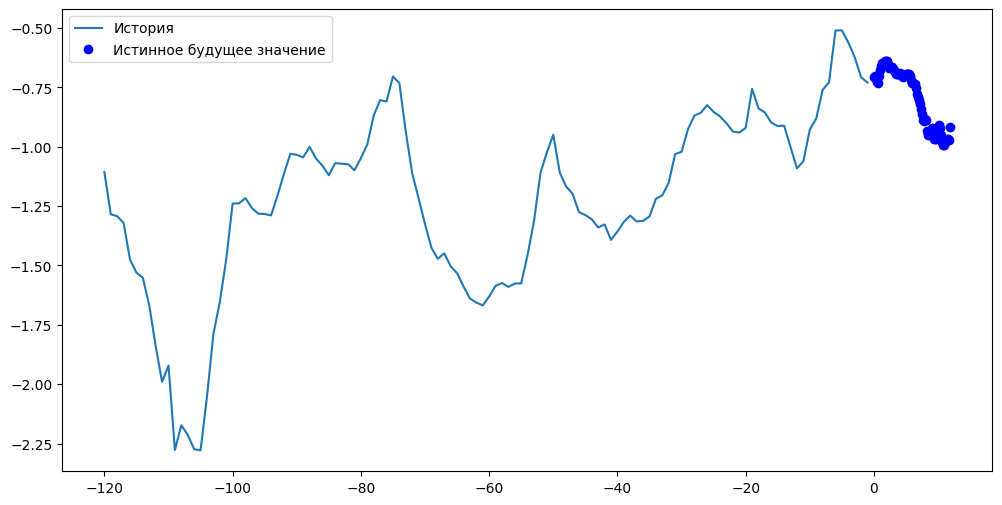

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 21ms/step
(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 49s 230ms/step - loss: 0.7502 - val_loss: 0.3352
Epoch 2/10
200/200 [==============================] - 39s 194ms/step - loss: 0.8510 - val_loss: 0.2875
Epoch 3/10
200/200 [==============================] - 36s 181ms/step - loss: 0.3777 - val_loss: 0.2786
Epoch 4/10
200/200 [==============================] - 42s 212ms/step - loss: 0.3173 - val_loss: 0.2420
Epoch 5/10
200/200 [==============================] - 45s 224ms/step - loss: 0.2236 - val_loss: 0.2177
Epoch 6/10
200/200 [==============================] - 45s 223ms/step - loss: 0.2194 - val_loss: 0.2192
Epoch 7/10
200/200 [==============================] - 38s 190ms/step - loss: 0.2069 - val_loss: 0.2063
Epoch 8/10
200/200 [==============================] - 38s 188ms/step - loss: 0.2031 - val_loss: 0.2080
Epoch 9/10
200/200 [==============================] - 39s 195ms/step - loss: 0.2064 - val_loss: 0.1969
Epoch 10/10
200/200 [==============================] - 44s 220ms/step - l

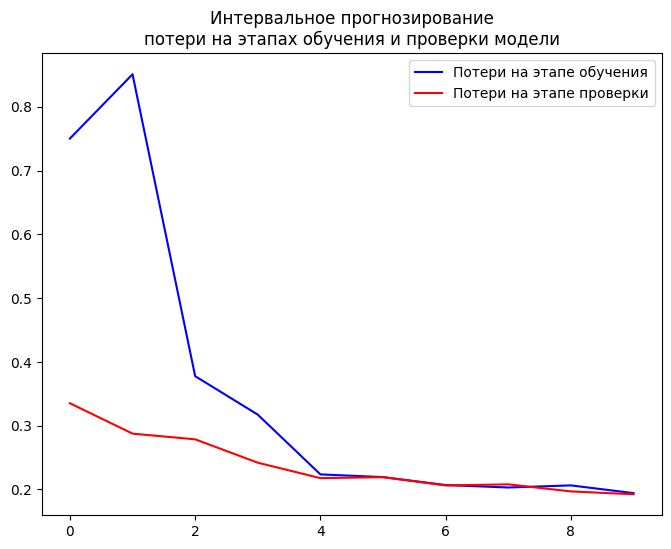

In [ ]:
plot_train_history(multi_step_history, 'Интервальное прогнозирование\nпотери на этапах обучения и проверки модели')

8/8 [==============================] - 0s 22ms/step


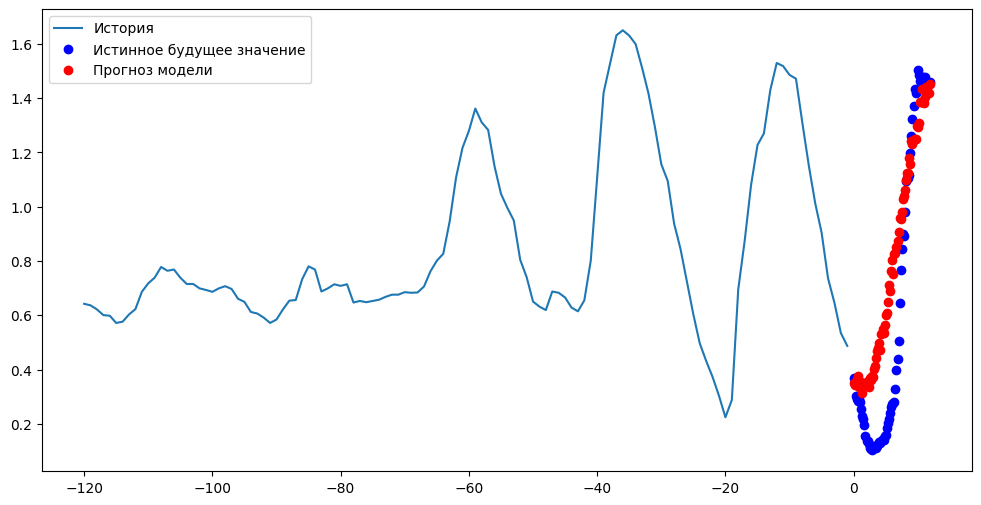

8/8 [==============================] - 0s 21ms/step


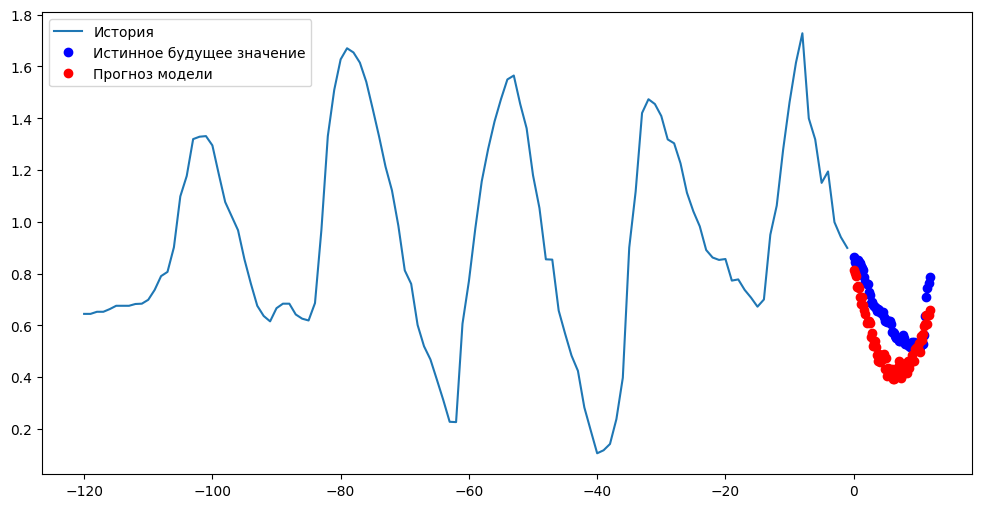

8/8 [==============================] - 0s 22ms/step


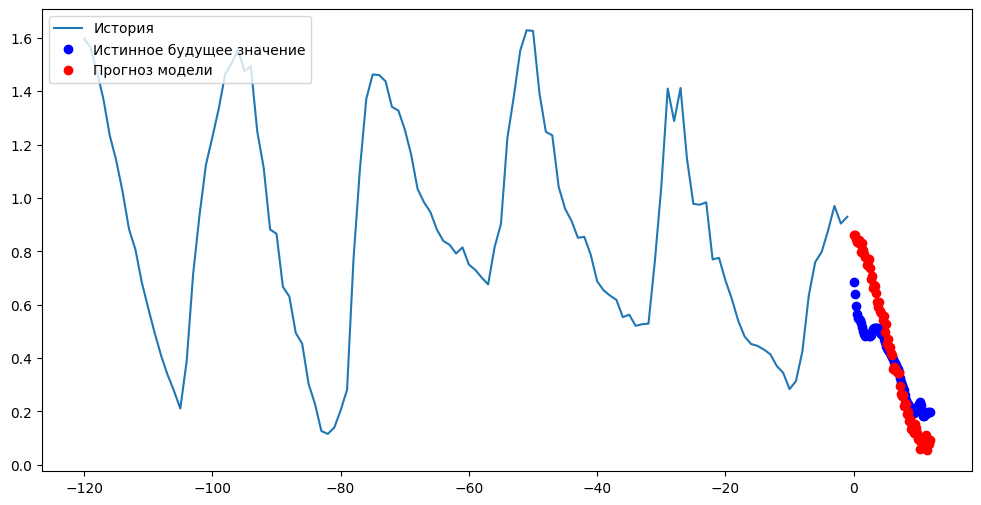

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.SimpleRNN(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.SimpleRNN(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 0s 13ms/step
(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 17s 76ms/step - loss: 0.4267 - val_loss: 0.2381
Epoch 2/10
200/200 [==============================] - 14s 72ms/step - loss: 0.2505 - val_loss: 0.2148
Epoch 3/10
200/200 [==============================] - 14s 70ms/step - loss: 0.2418 - val_loss: 0.2073
Epoch 4/10
200/200 [==============================] - 14s 71ms/step - loss: 0.2220 - val_loss: 0.1961
Epoch 5/10
200/200 [==============================] - 14s 70ms/step - loss: 0.1941 - val_loss: 0.1962
Epoch 6/10
200/200 [==============================] - 14s 70ms/step - loss: 0.2084 - val_loss: 0.2090
Epoch 7/10
200/200 [==============================] - 17s 83ms/step - loss: 0.2029 - val_loss: 0.2045
Epoch 8/10
200/200 [==============================] - 14s 71ms/step - loss: 0.1989 - val_loss: 0.1889
Epoch 9/10
200/200 [==============================] - 14s 71ms/step - loss: 0.2056 - val_loss: 0.1910
Epoch 10/10
200/200 [==============================] - 15s 76ms/step - loss: 0.195

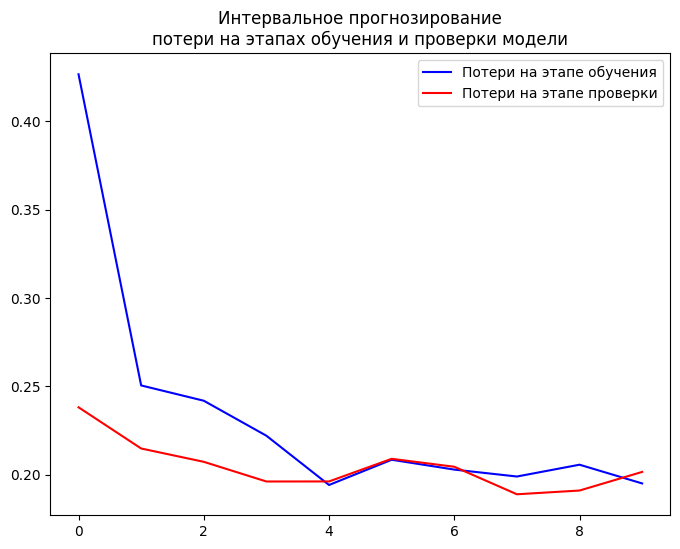

In [ ]:
plot_train_history(multi_step_history, 'Интервальное прогнозирование\nпотери на этапах обучения и проверки модели')

8/8 [==============================] - 0s 12ms/step


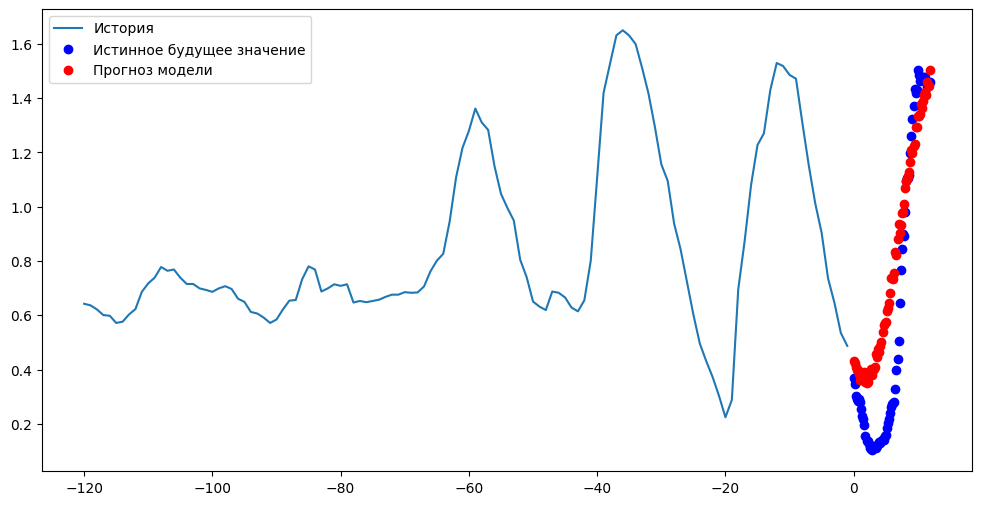

8/8 [==============================] - 0s 12ms/step


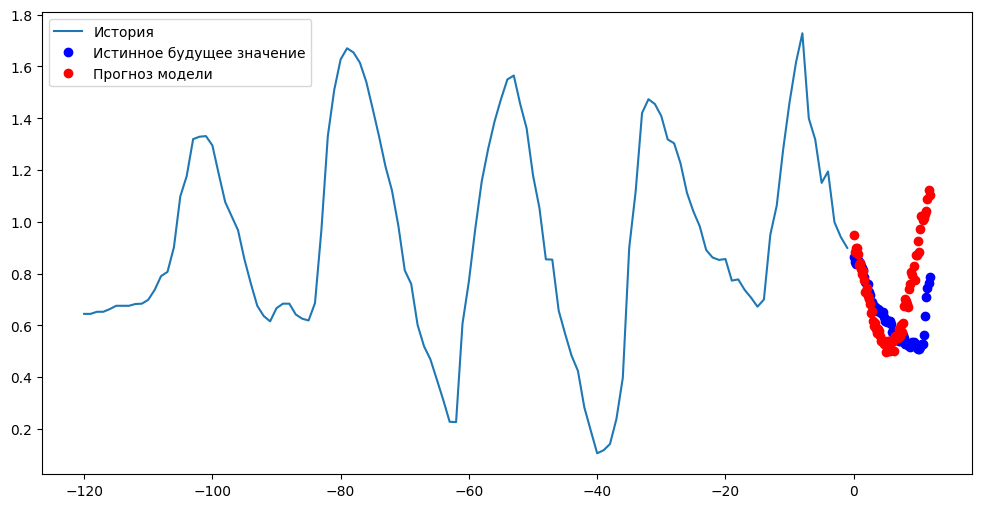

8/8 [==============================] - 0s 12ms/step


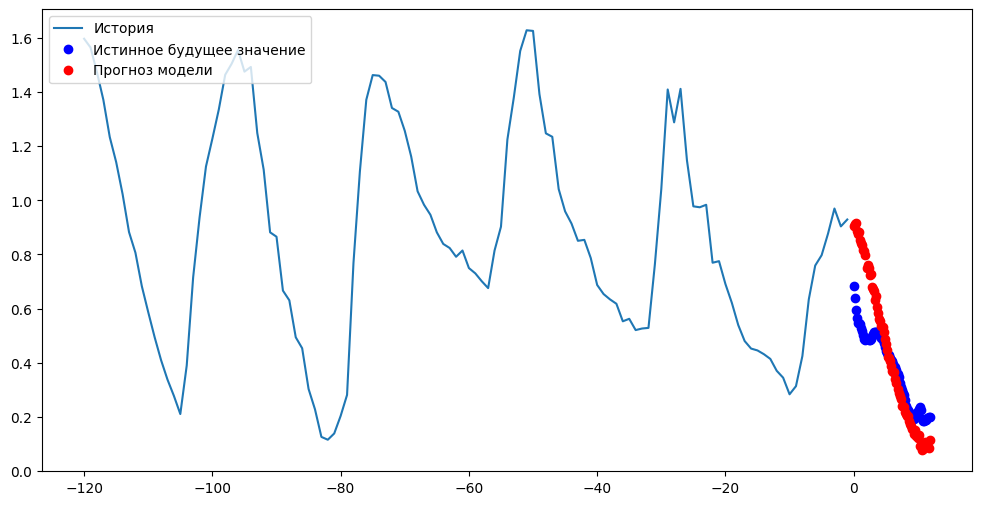

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
#ЗАДАНИЕ 2.

In [ ]:
df = pd.read_csv("aqidataset.csv")
df.head()

,Unnamed: 0,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),Ozone,PM25,CO,PM10,NO2,AQI category,city,state
0,0,01/01/2023,28,Ozone,Connecticut Hill,36-109-9991,AQS,28,.,NaN,NaN,NaN,Good,Ithaca,NY
1,1,01/02/2023,26,Ozone,Connecticut Hill,36-109-9991,AQS,26,.,NaN,NaN,NaN,Good,Ithaca,NY
2,2,01/03/2023,21,Ozone,Connecticut Hill,36-109-9991,AQS,21,.,NaN,NaN,NaN,Good,Ithaca,NY
3,3,01/04/2023,25,Ozone,Connecticut Hill,36-109-9991,AQS,25,.,NaN,NaN,NaN,Good,Ithaca,NY
4,4,01/05/2023,31,Ozone,Connecticut Hill,36-109-9991,AQS,31,.,NaN,NaN,NaN,Good,Ithaca,NY


In [ ]:
df = df.dropna()
df.head()

,Unnamed: 0,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),Ozone,PM25,CO,PM10,NO2,AQI category,city,state
357,357,01/01/2023,74,PM2.5,REGIONAL OFFICE BUILDING,17-031-4007,AQS,15,74,7,26.0,21.0,Moderate,Chicago,IL
358,358,01/02/2023,73,PM2.5,Hammond- 167th St,18-089-0036,AQS,19,73,7,19.0,28.0,Moderate,Chicago,IL
359,359,01/03/2023,55,PM2.5,Hammond- 167th St,18-089-0036,AQS,19,55,6,31.0,25.0,Moderate,Chicago,IL
360,360,01/04/2023,37,PM2.5,VILLAGE GARAGE,17-031-0001,AQS,21,37,3,17.0,25.0,Good,Chicago,IL
361,361,01/05/2023,54,PM2.5,CHIWAUKEE PRAIRIE STATELINE,55-059-0019,AQS,20,54,5,19.0,29.0,Moderate,Chicago,IL


In [ ]:
import numpy as np

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        # Убедимся, что end_index меньше размера массива, учитывая target_size
        end_index = len(dataset) - target_size - 1 # Добавляем -1, чтобы избежать выхода за пределы

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        # Проверяем, что i+target_size не выходит за пределы массива
        if i+target_size < len(dataset):
            labels.append(dataset[i+target_size])
        else:
            # Если i+target_size выходит за пределы, добавляем None или другое подходящее значение
            labels.append(None)

    return np.array(data), np.array(labels)


In [ ]:
TRAIN_SPLIT = 7000

In [ ]:
tf.random.set_seed(13)

In [ ]:
uni_data = df['Overall AQI Value']
uni_data.index = df['Date']
uni_data.head()

Date
01/01/2023    74
01/02/2023    73
01/03/2023    55
01/04/2023    37
01/05/2023    54
Name: Overall AQI Value, dtype: int64

array([<Axes: xlabel='Date'>], dtype=object)

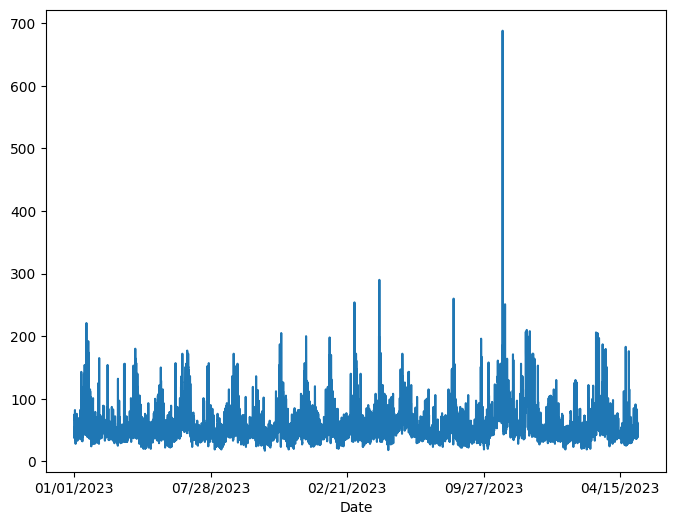

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Временной интервал для наблюдений')
print (x_train_uni[0])
print ('\n Целевое значние индекса качества воздуха для прогнозирования')
print (y_train_uni[0])

Временной интервал для наблюдений
[[ 0.57421282]
 [ 0.53894021]
 [-0.09596668]
 [-0.73087358]
 [-0.13123929]
 [-0.2017845 ]
 [-0.06069408]
 [-0.02542147]
 [ 0.64475803]
 [ 0.29203198]]

 Целевое значние индекса качества воздуха для прогнозирования
0.8563936622988672


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['История', 'Истинное будущее значение', 'Прогноз модели']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Временной интервал')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

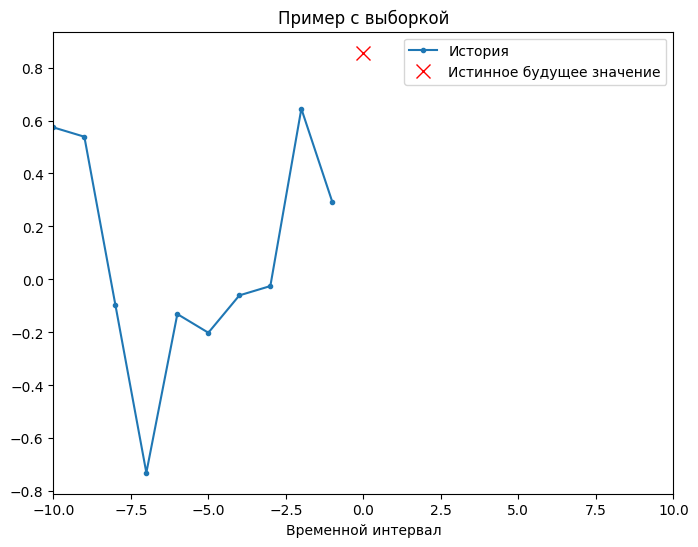

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

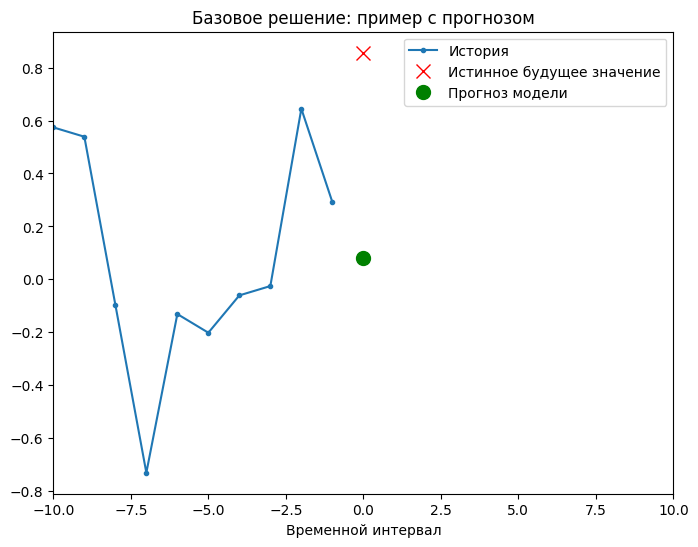

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Базовое решение: пример с прогнозом')

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 3ms/step
(256, 1)


In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 6s 17ms/step - loss: 0.5405 - val_loss: 0.4702
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4850 - val_loss: 0.4308
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4626 - val_loss: 0.4129
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4540 - val_loss: 0.4077
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4531 - val_loss: 0.4062
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4506 - val_loss: 0.4056
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4505 - val_loss: 0.4052
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.4497 - val_loss: 0.4049
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4500 - val_loss: 0.4042
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4510 - val_loss: 0.40

8/8 [==============================] - 0s 4ms/step


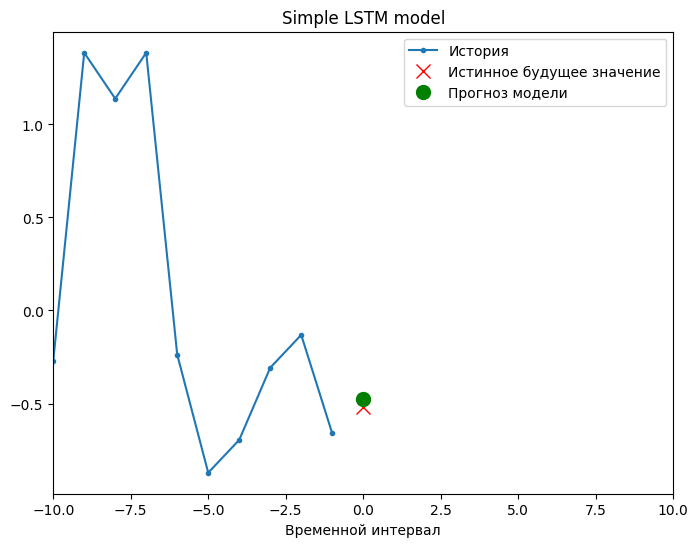

8/8 [==============================] - 0s 11ms/step


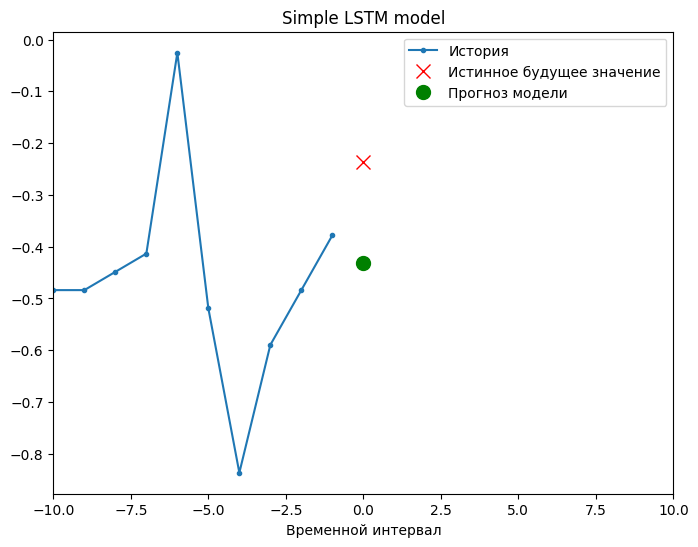

8/8 [==============================] - 0s 12ms/step


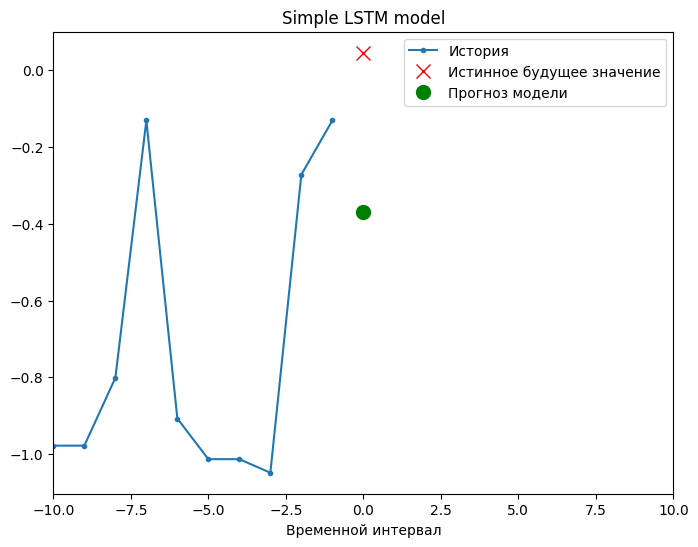

8/8 [==============================] - 0s 5ms/step


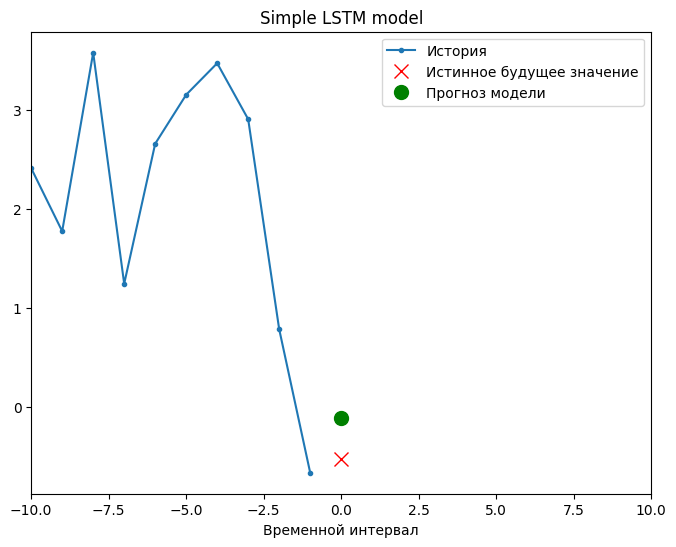

8/8 [==============================] - 1s 4ms/step


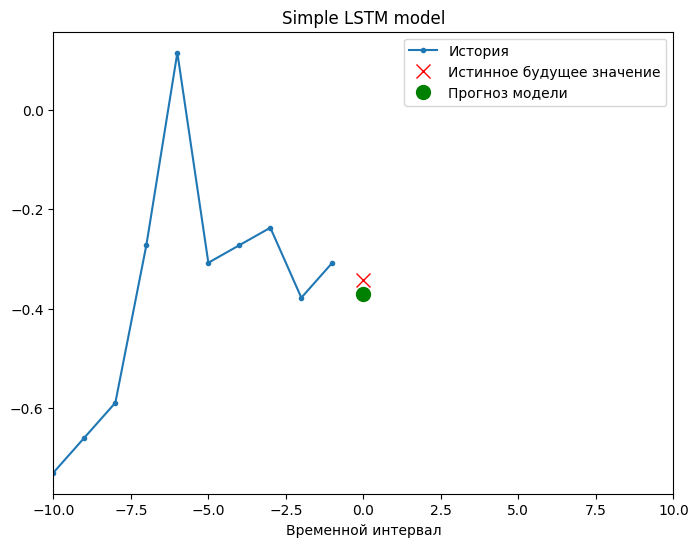

In [ ]:
for x, y in val_univariate.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [ ]:
features_considered = ['Ozone', 'PM25', 'NO2']

In [ ]:
import pandas as pd
df = df.dropna()
features = df[features_considered]

features = features.apply(pd.to_numeric, errors='coerce')

features.index = df['Date']
features = features.fillna(0)
features.head()



,Ozone,PM25,NO2
Date,,,
01/01/2023,15.0,74.0,21.0
01/02/2023,19.0,73.0,28.0
01/03/2023,19.0,55.0,25.0
01/04/2023,21.0,37.0,25.0
01/05/2023,20.0,54.0,29.0


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

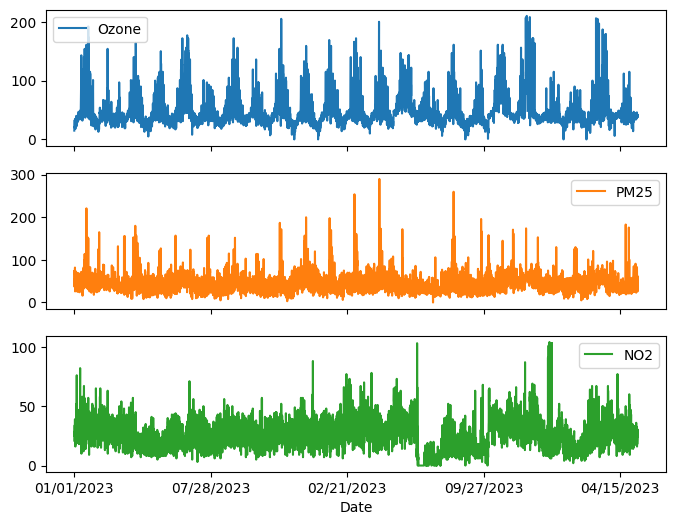

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 1s 11ms/step
(256, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=100)

Epoch 1/10
200/200 [==============================] - 24s 109ms/step - loss: 0.6758 - val_loss: 0.6344
Epoch 2/10
200/200 [==============================] - 21s 107ms/step - loss: 0.6432 - val_loss: 0.6522
Epoch 3/10
200/200 [==============================] - 21s 104ms/step - loss: 0.6304 - val_loss: 0.6440
Epoch 4/10
200/200 [==============================] - 20s 100ms/step - loss: 0.6209 - val_loss: 0.6582
Epoch 5/10
200/200 [==============================] - 22s 110ms/step - loss: 0.6130 - val_loss: 0.6164
Epoch 6/10
200/200 [==============================] - 20s 101ms/step - loss: 0.6067 - val_loss: 0.6604
Epoch 7/10
200/200 [==============================] - 20s 98ms/step - loss: 0.6035 - val_loss: 0.6607
Epoch 8/10
200/200 [==============================] - 21s 103ms/step - loss: 0.5999 - val_loss: 0.6543
Epoch 9/10
200/200 [==============================] - 20s 98ms/step - loss: 0.5966 - val_loss: 0.6557
Epoch 10/10
200/200 [==============================] - 20s 101ms/step - los

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

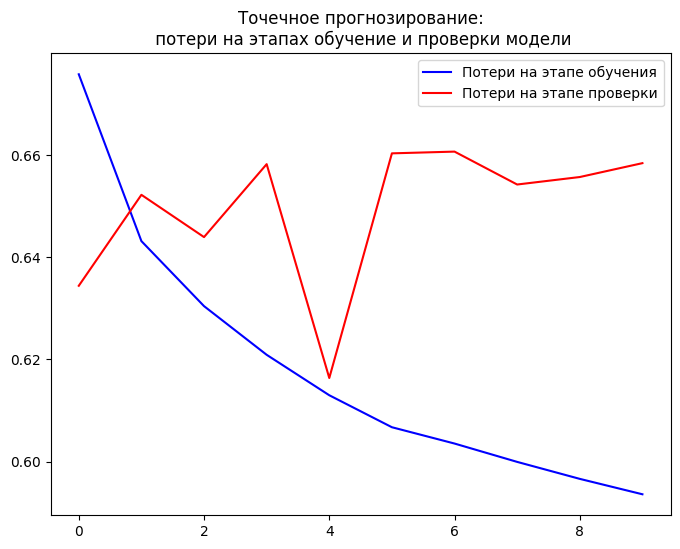

In [ ]:
plot_train_history(single_step_history,
                   'Точечное прогнозирование:\n потери на этапах обучение и проверки модели')

8/8 [==============================] - 0s 16ms/step


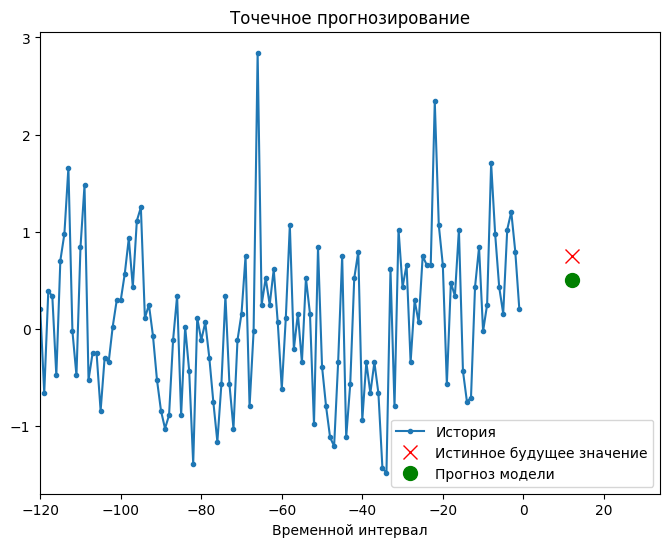

7/7 [==============================] - 1s 16ms/step


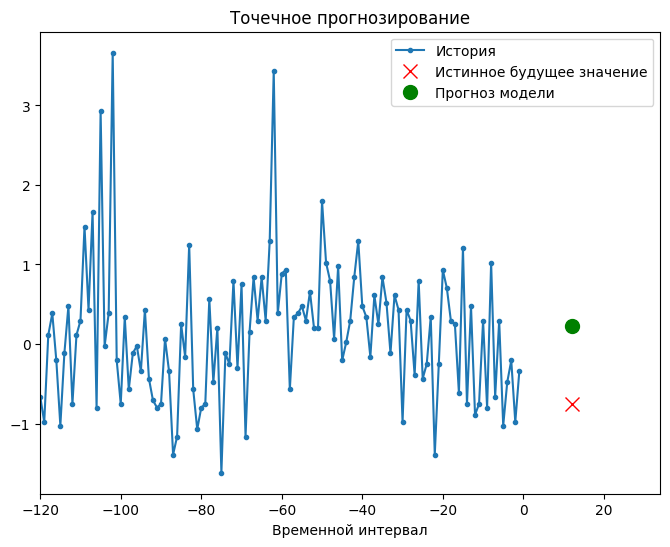

8/8 [==============================] - 0s 19ms/step


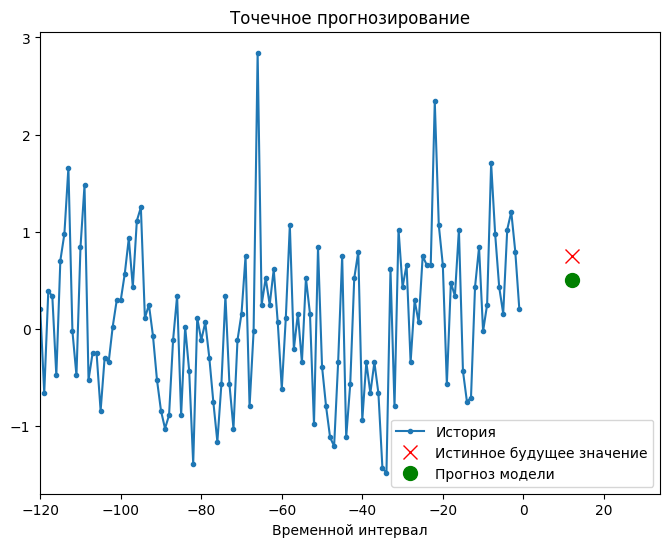

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Точечное прогнозирование')
  plot.show()

In [ ]:
future_target = 75
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Временной интервал для наблюдений : {}'.format(x_train_multi[0].shape))
print ('\n Целевая температура для прогнозирования : {}'.format(y_train_multi[0].shape))

Временной интервал для наблюдений : (120, 3)

 Целевая температура для прогнозирования : (75,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='История')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='Истинное будущее значение')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Прогноз модели')
  plt.legend(loc='upper left')
  plt.show()

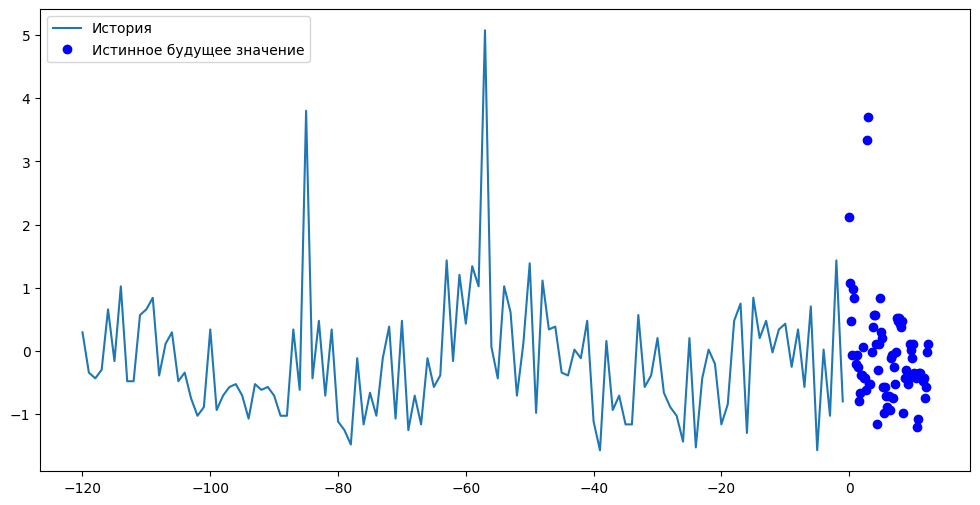

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(75))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 21ms/step
(256, 75)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 69s 186ms/step - loss: 0.7009 - val_loss: 0.6091
Epoch 2/10
200/200 [==============================] - 36s 182ms/step - loss: 0.6674 - val_loss: 0.6069
Epoch 3/10
200/200 [==============================] - 37s 183ms/step - loss: 0.6376 - val_loss: 0.6277
Epoch 4/10
200/200 [==============================] - 36s 182ms/step - loss: 0.6273 - val_loss: 0.6305
Epoch 5/10
200/200 [==============================] - 37s 184ms/step - loss: 0.6205 - val_loss: 0.6358
Epoch 6/10
200/200 [==============================] - 35s 177ms/step - loss: 0.6149 - val_loss: 0.6371
Epoch 7/10
200/200 [==============================] - 36s 177ms/step - loss: 0.6111 - val_loss: 0.6319
Epoch 8/10
200/200 [==============================] - 36s 180ms/step - loss: 0.6084 - val_loss: 0.6286
Epoch 9/10
200/200 [==============================] - 38s 191ms/step - loss: 0.6061 - val_loss: 0.6396
Epoch 10/10
200/200 [==============================] - 36s 181ms/step - l

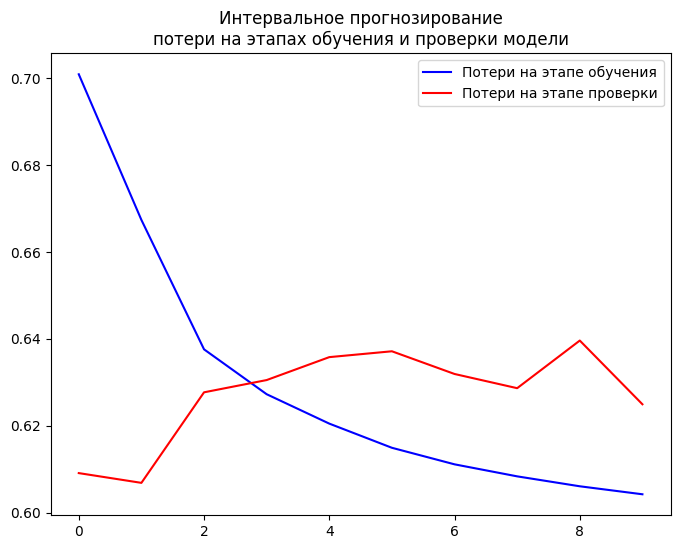

In [ ]:
plot_train_history(multi_step_history, 'Интервальное прогнозирование\nпотери на этапах обучения и проверки модели')

8/8 [==============================] - 1s 63ms/step


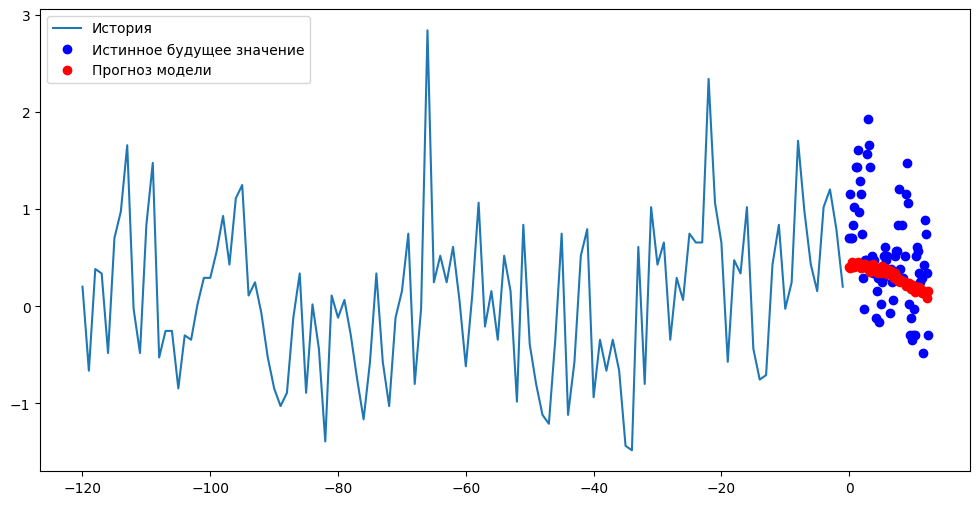

7/7 [==============================] - 2s 36ms/step


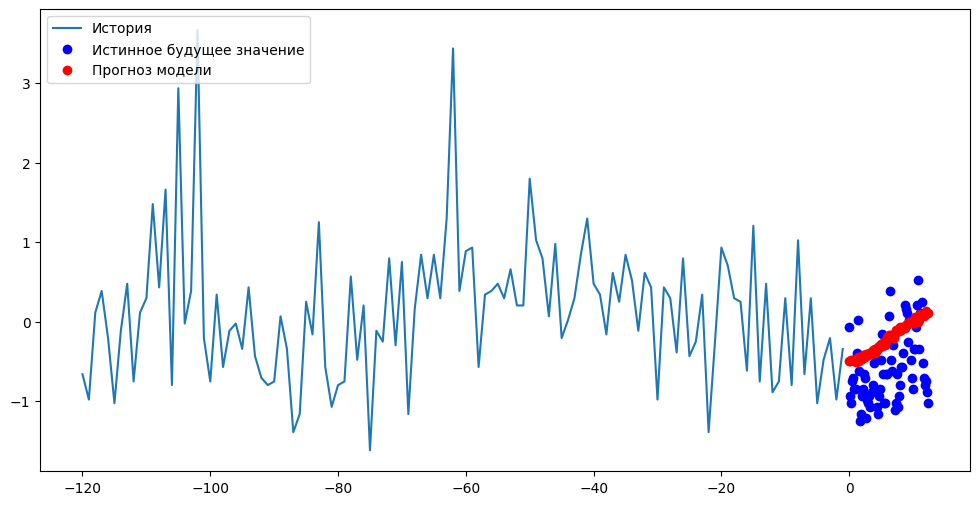

8/8 [==============================] - 0s 37ms/step


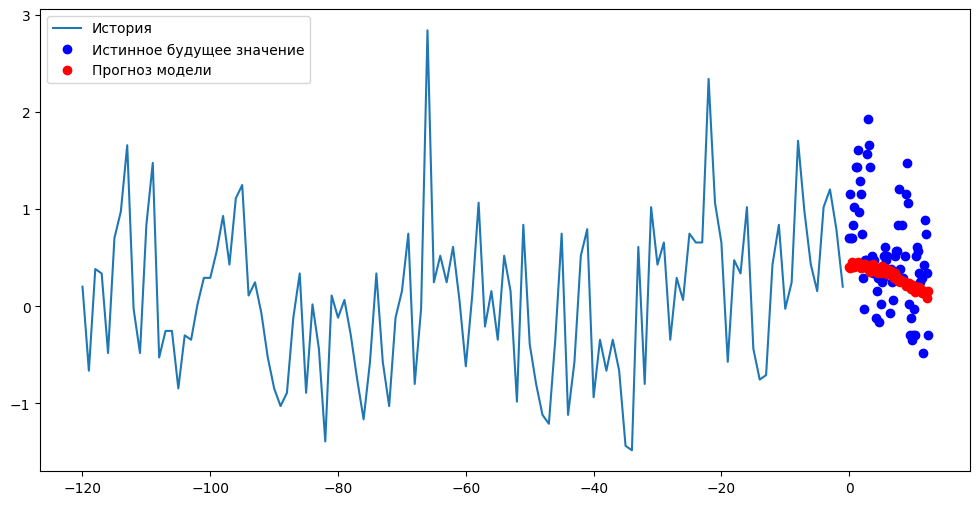

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])